In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# Dataset

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

In [3]:
!wget $data -O data-week-2.csv 

--2025-09-30 17:54:12--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘data-week-2.csv’

data-week-2.csv     100%[===================>] 853.70K  --.-KB/s    in 0.03s   

2025-09-30 17:54:12 (24.0 MB/s) - ‘data-week-2.csv’ saved [874188/874188]



In [4]:
df = pd.read_csv('data-week-2.csv')

In [5]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


# Preparing the dataset

In [6]:
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[cols]
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


# EDA

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

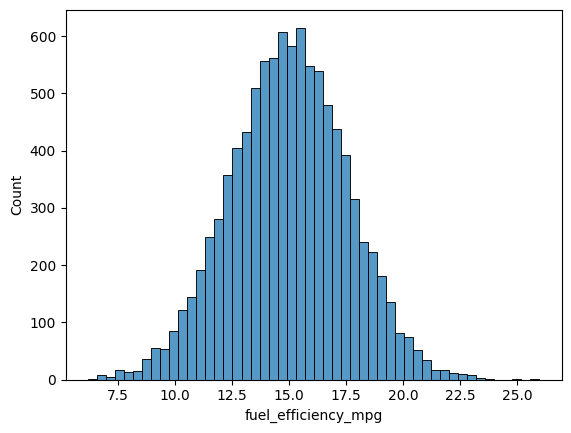

In [7]:
sns.histplot(df.fuel_efficiency_mpg, bins=50)

# Question 1

In [8]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

# Question 2

In [9]:
df['horsepower'].median().round(2)

np.float64(149.0)

## Prepare and split the dataset

In [10]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [11]:
n_train, n_val, n_test, n

(5824, 1940, 1940, 9704)

In [12]:
idx = np.arange(n)

In [13]:
np.random.seed(42)
np.random.shuffle(idx)

In [14]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [15]:
len(df_train), len(df_val), len(df_test)

(5824, 1940, 1940)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

In [18]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [19]:
len(y_train)

5824

# Question 3

In [20]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [21]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [22]:
def prepare_X(df, fillna_value):
    df = df.copy()
    df = df.fillna(fillna_value)
    X = df.values
    return X

## with mean

In [23]:
mean_df_train = df_train.horsepower.mean()

X_train = prepare_X(df_train, fillna_value=mean_df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna_value=mean_df_train)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.03732771701389712)

## with zero

In [24]:
X_train = prepare_X(df_train, fillna_value=0)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna_value=0)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.03997925782374439)

# Question 4

In [25]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [26]:
X_train = prepare_X(df_train, fillna_value=0)
X_val = prepare_X(df_val, fillna_value=0)

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)

    y_pred = w_0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, score)

0 0.03997925782374439
0.01 0.03997787201684389
0.1 0.04050873984529611
1 0.04135385150821747
5 0.04150611823271757
10 0.041526801237522025
100 0.04154575656081135


# Question 5

In [27]:
res = {}

In [28]:
for i in range(0,9):
    np.random.seed(i)
    np.random.shuffle(idx)
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
    y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
    y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    X_train = prepare_X(df_train, fillna_value=0)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, fillna_value=0)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)

    res.update({i: score})

In [29]:
res

{0: np.float64(0.03954193959330701),
 1: np.float64(0.03802292082197706),
 2: np.float64(0.038771181836906),
 3: np.float64(0.039073335077667276),
 4: np.float64(0.03868268781347268),
 5: np.float64(0.04000630670323209),
 6: np.float64(0.038305668933596285),
 7: np.float64(0.03850994813794094),
 8: np.float64(0.039020078337727686)}

In [30]:
values = list(res.values())

In [31]:
std_dev = np.std(values).round(3)
print(std_dev)

0.001


# Question 6

In [32]:
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

X_full_train = prepare_X(df_full_train, fillna_value=0)
y_full_train = np.concatenate([y_train, y_val])
w_0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

X_test = prepare_X(df_test, fillna_value=0)
y_pred = w_0 + X_test.dot(w)

y_pred_lin = np.expm1(y_pred)
y_test_lin = np.expm1(y_test)
result = rmse(y_test_lin, y_pred_lin)
print(result)

0.6073861396225164
